In [1]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

In [3]:
!wget -P ../data/ https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

--2024-03-19 18:09:43--  https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.222.236.65, 52.222.236.74, 52.222.236.115, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.222.236.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘../data/teapot.obj’

teapot.obj          100%[===================>] 149.02K   322KB/s    in 0.5s    

2024-03-19 18:09:45 (322 KB/s) - ‘../data/teapot.obj’ saved [152595/152595]



In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
# elif torch.backends.mps.is_available():
#     device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(f"Device is {device}")

Device is cpu


In [3]:
verts, faces_idx, _ = load_obj("../data/teapot.obj")
faces = faces_idx.verts_idx

verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

teapot_mesh = Meshes(
    verts=[verts.to(device)], faces=[faces.to(device)], textures=textures
)

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/NIE/lib/python3.10/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/opt/homebrew/anaconda3/envs/NIE/lib/python3.10/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/opt/homebrew/anaconda3/envs/NIE/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [4]:
cameras = FoVPerspectiveCameras(device=device)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=np.log(1.0 / 1e-4 - 1.0) * blend_params.sigma,
    faces_per_pixel=100,
)
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftSilhouetteShader(blend_params=blend_params),
)

raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=HardPhongShader(device=device, lights=lights, cameras=cameras),
)

In [5]:
distance = 3  # distance from camera to the object
elevation = 50.0  # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis

R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

In [6]:
def plot_side_by_side(img1, img2, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.grid(False)
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.grid(False)

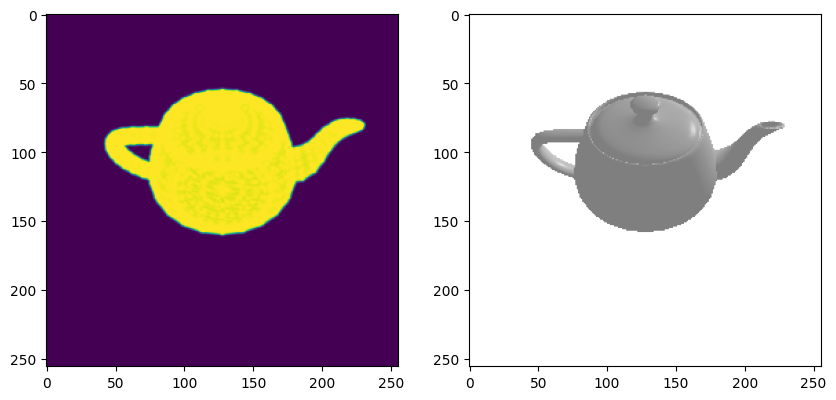

In [7]:
plot_side_by_side(silhouette.squeeze()[..., 3], image_ref.squeeze())

In [8]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        self.image_ref = torch.from_numpy(
            (image_ref[..., :3].max(-1) != 1).astype(np.float32)
        )
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0, 6.9, 2.5], dtype=np.float32)).to(
                self.device
            )
        )

    def forward(self):
        R = look_at_rotation(self.camera_position[None, :], device=self.device)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]

        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)

        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
        return loss, image

In [9]:
filename_out = "../results/teapot_optimization_demo.gif"
writer = imageio.get_writer(filename_out, mode="I", duration=0.3)

model = Model(teapot_mesh, silhouette_renderer, image_ref).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

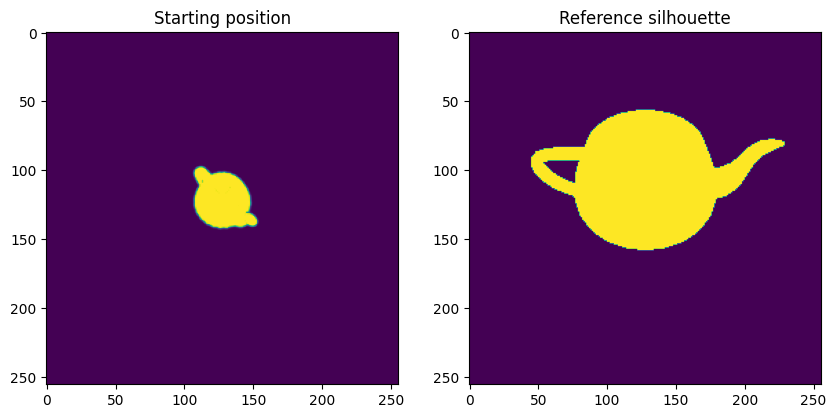

In [11]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette")
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

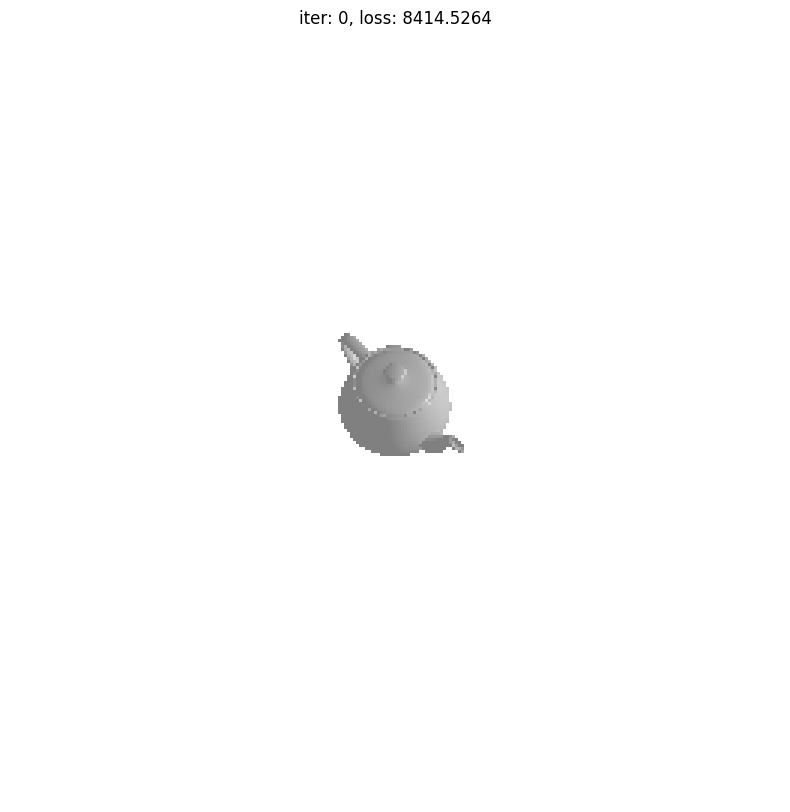

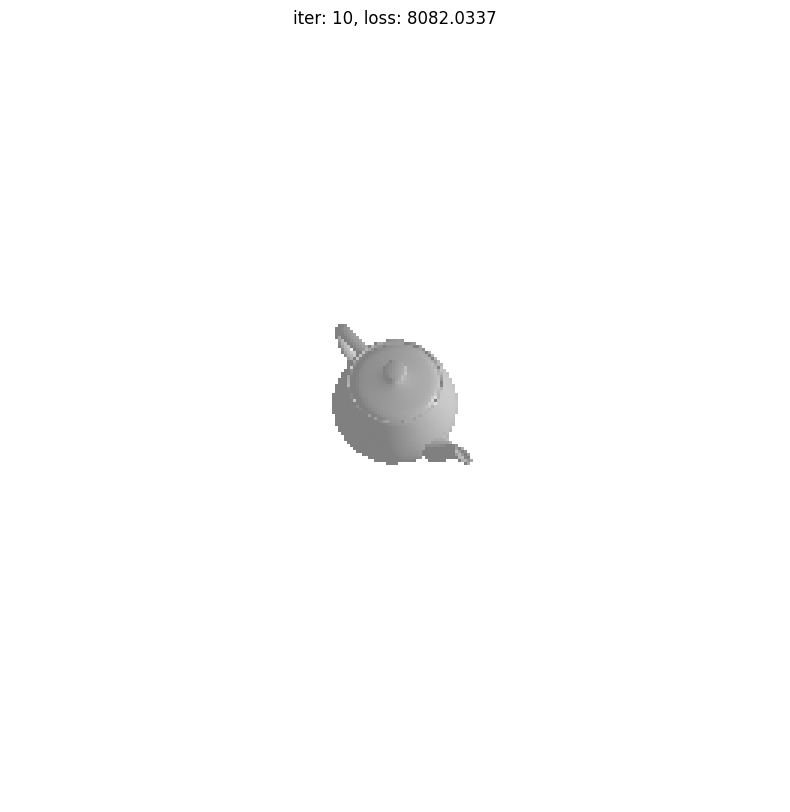

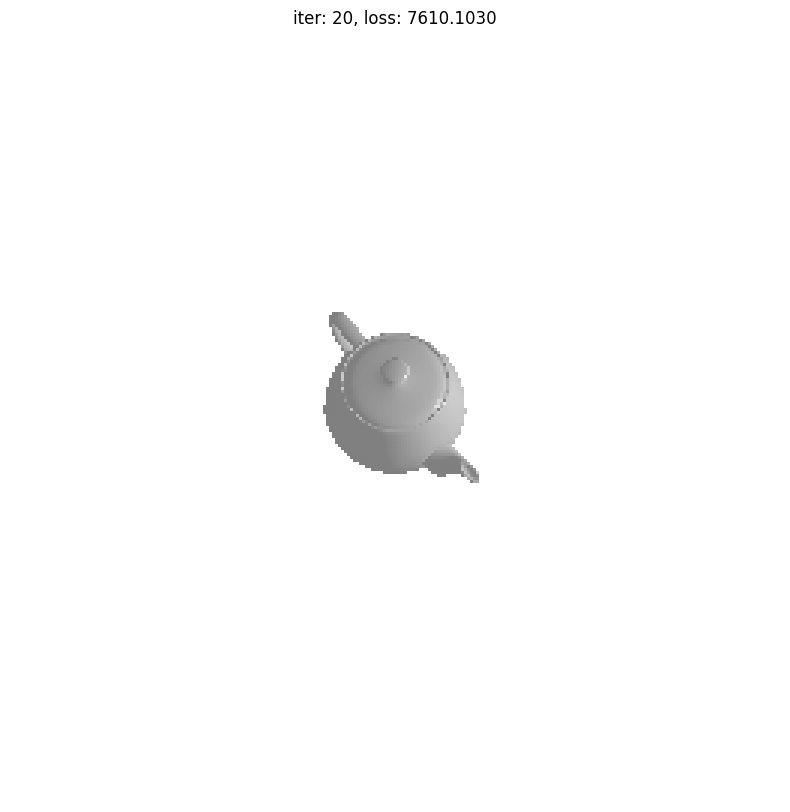

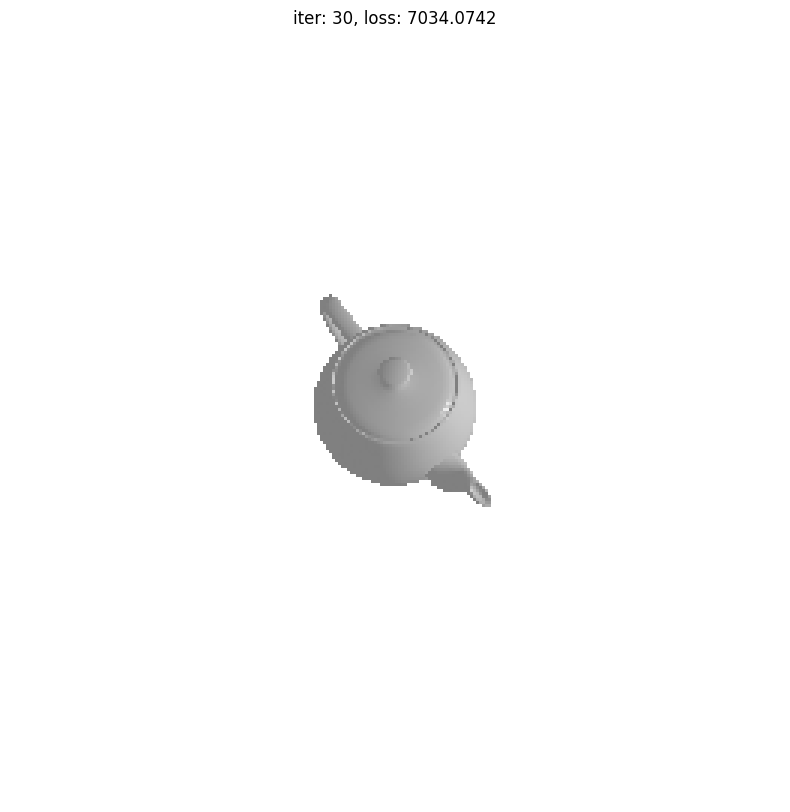

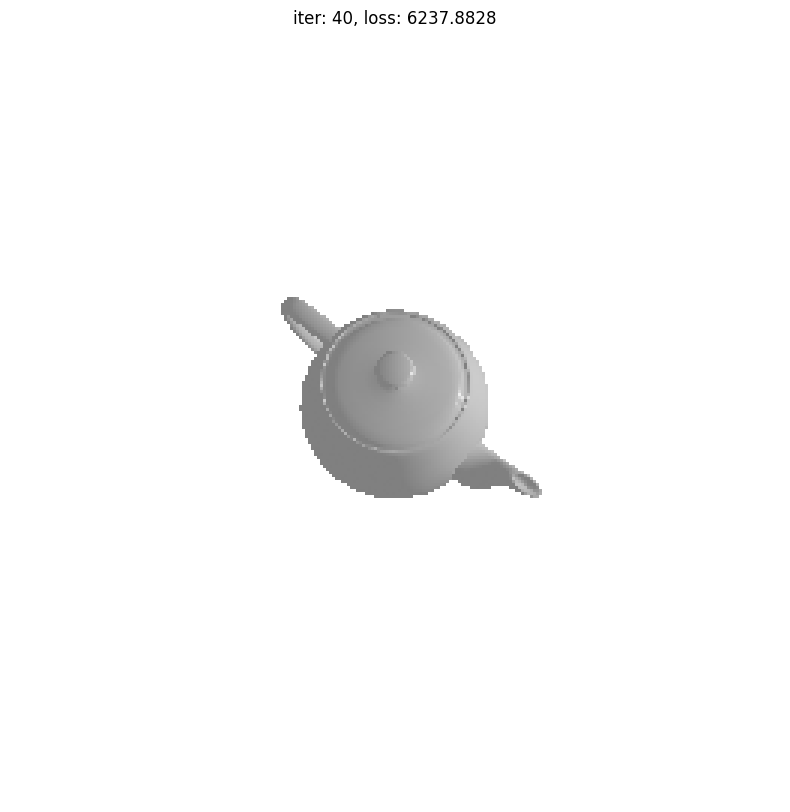

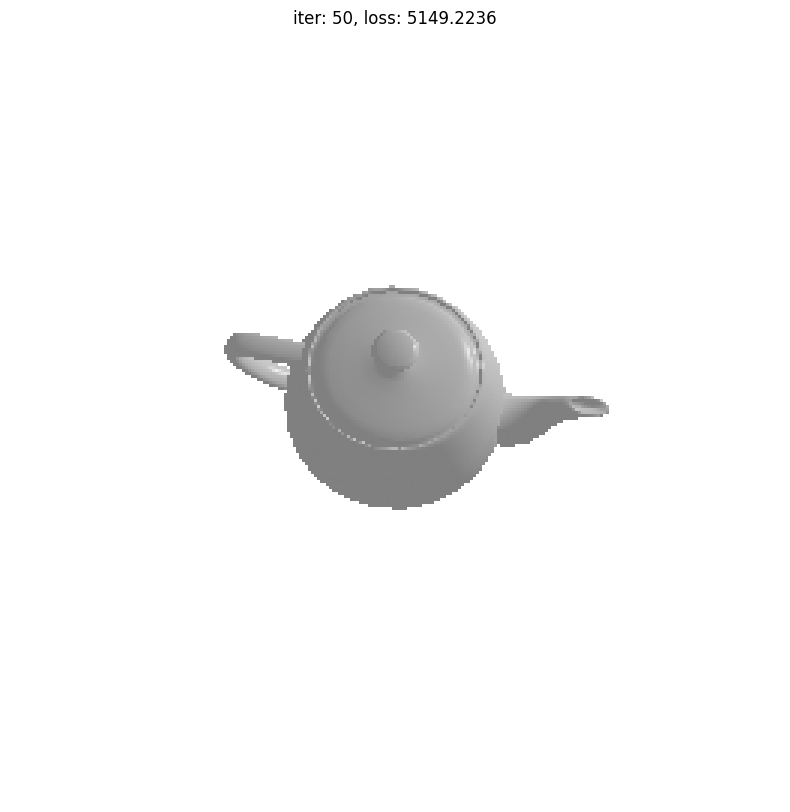

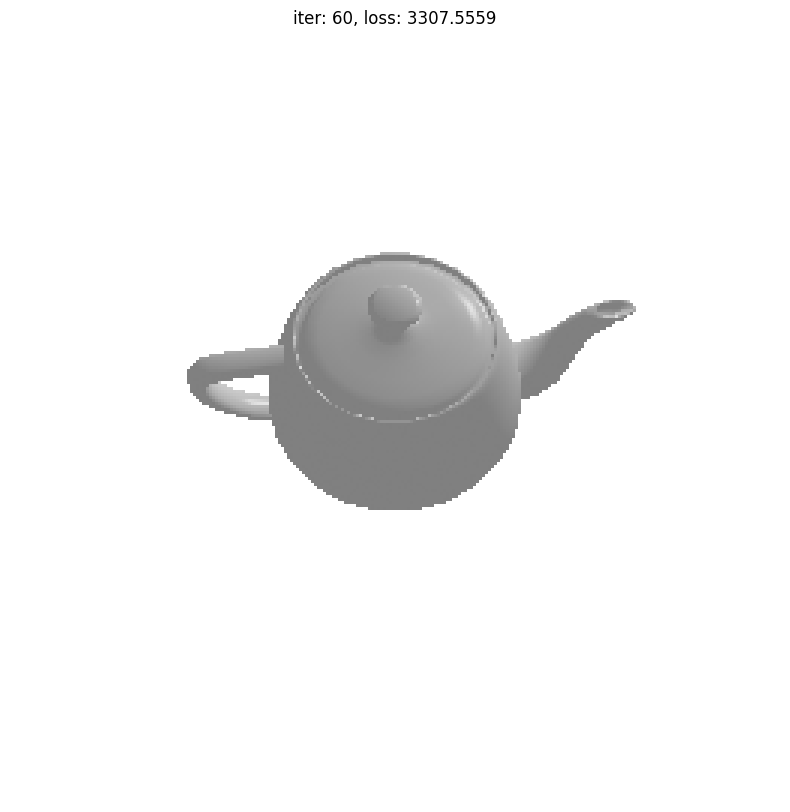

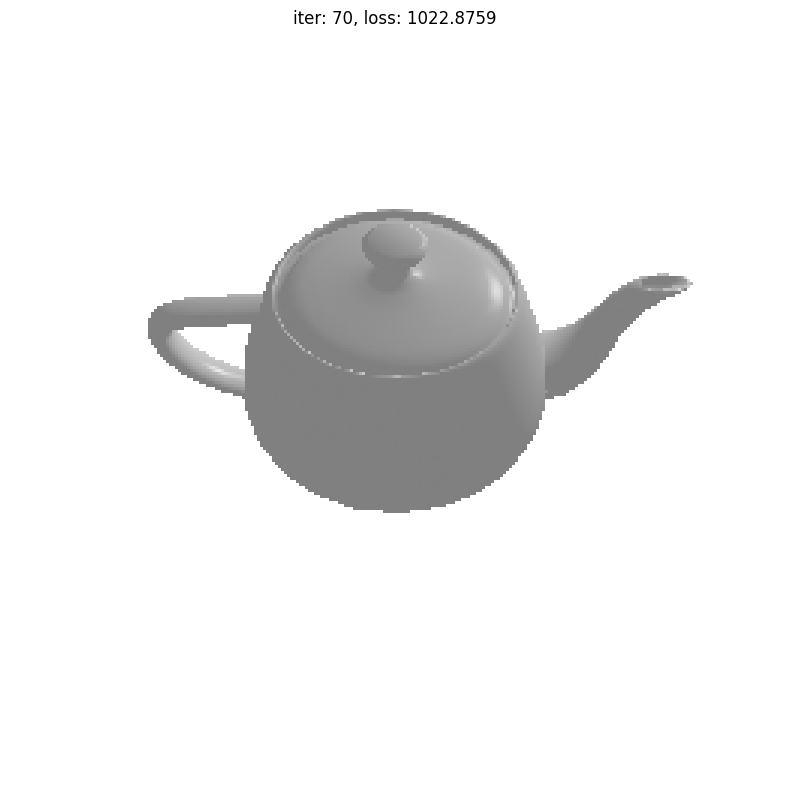

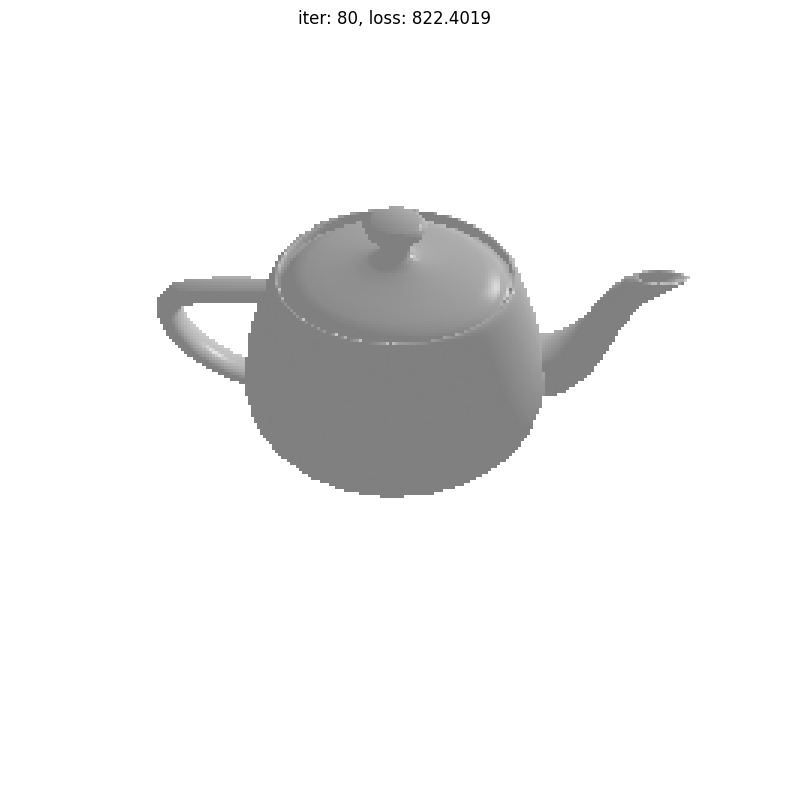

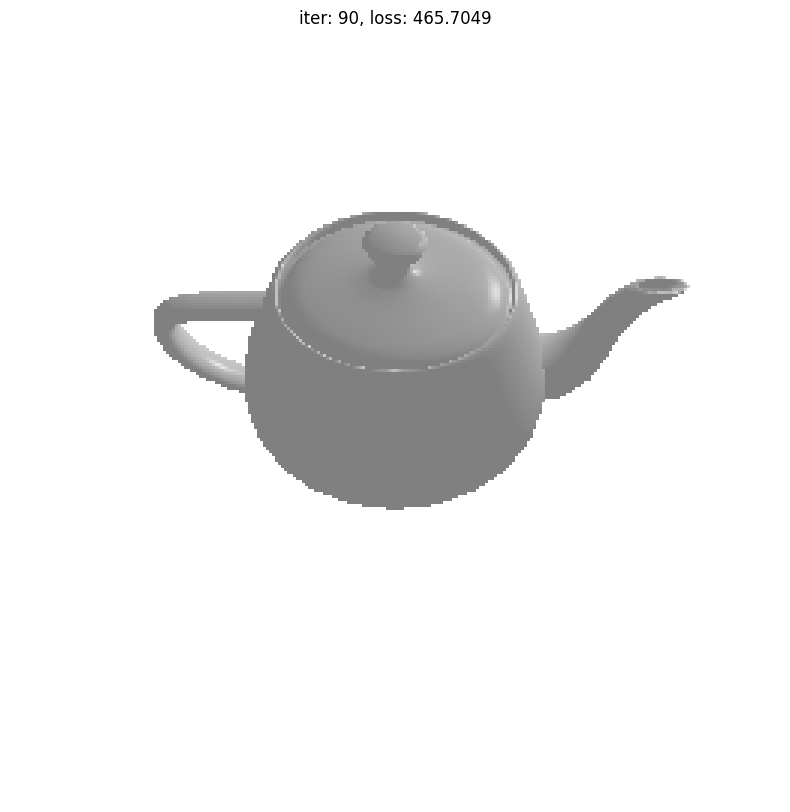

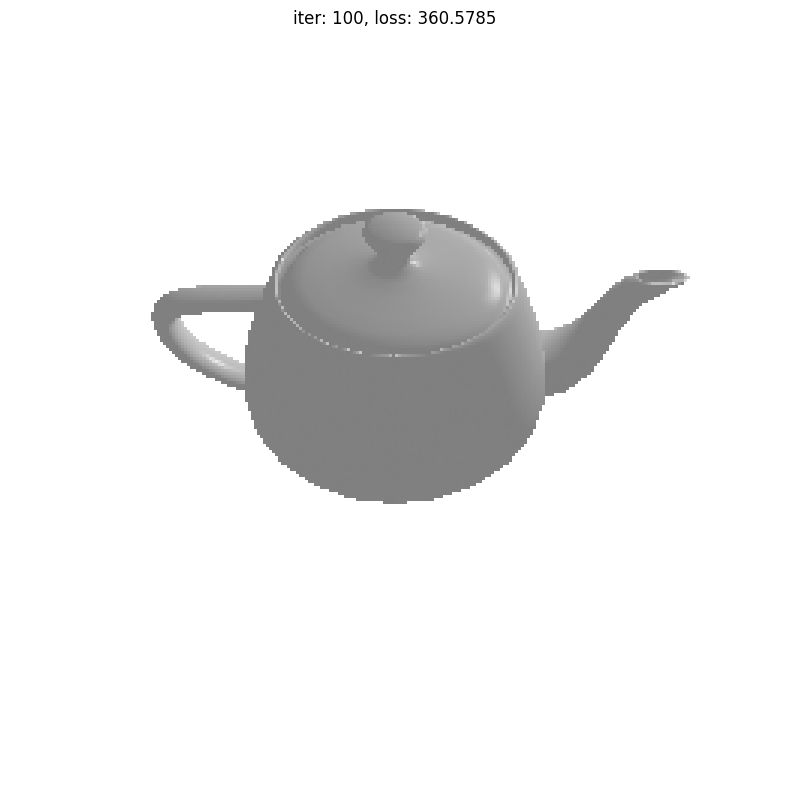

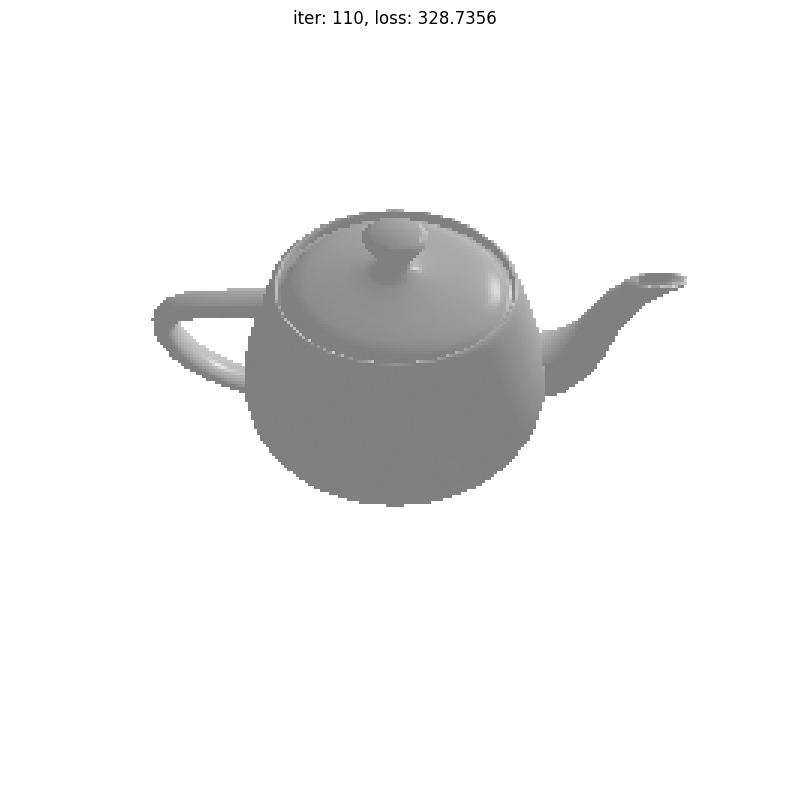

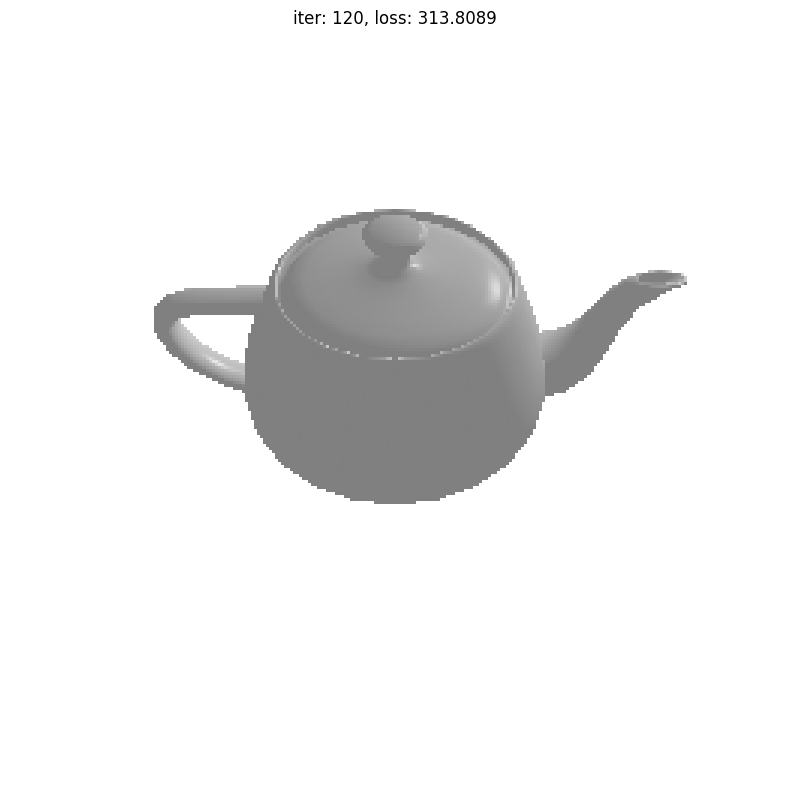

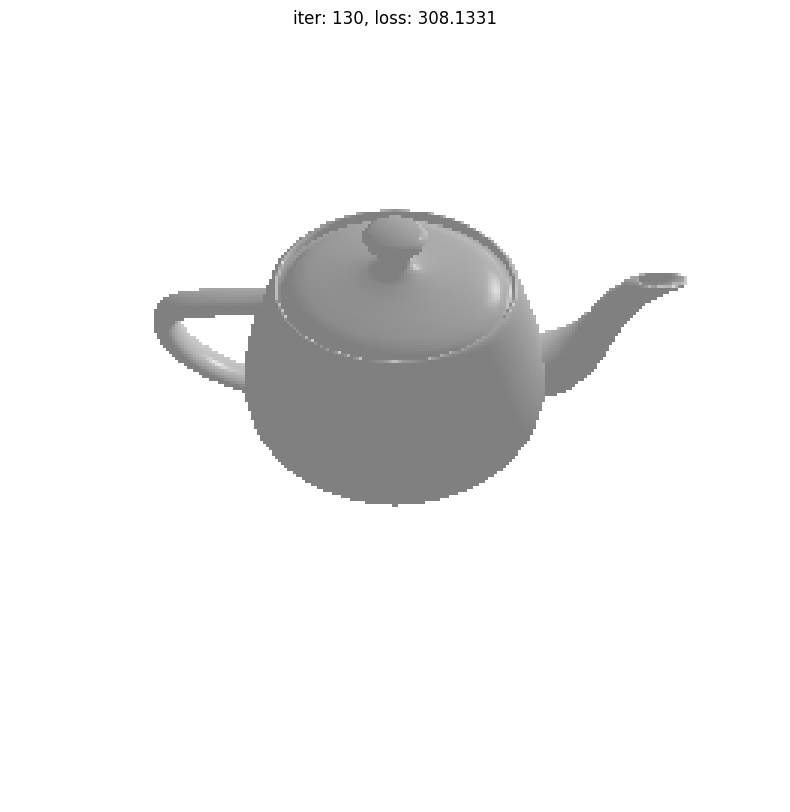

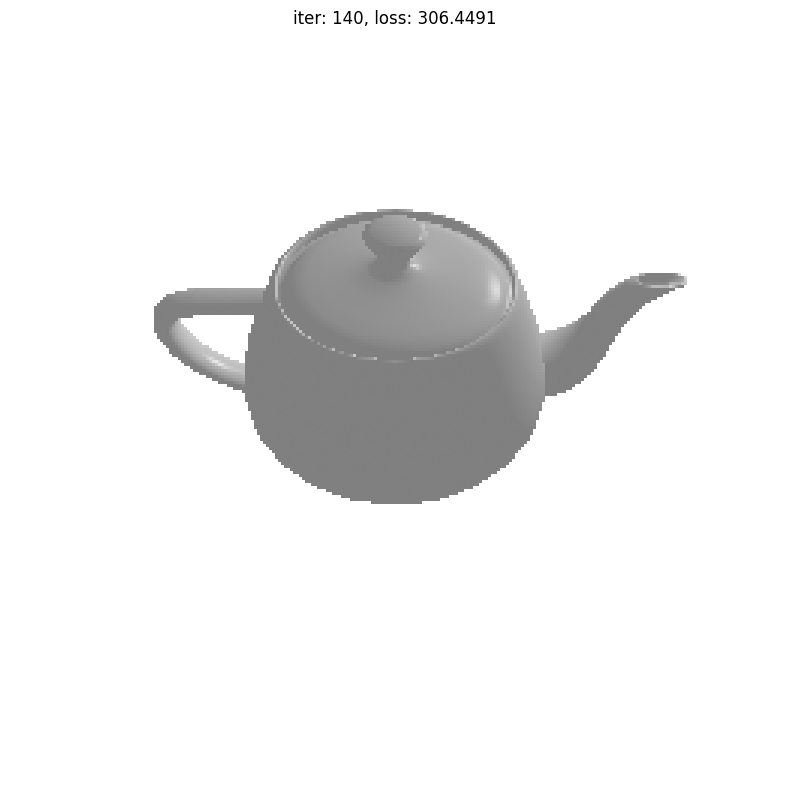

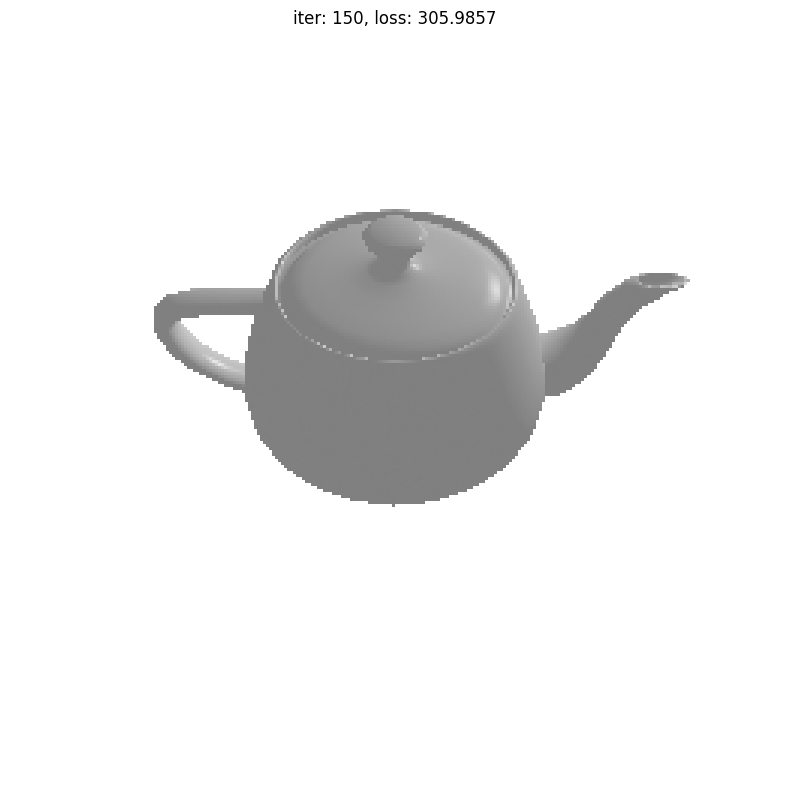

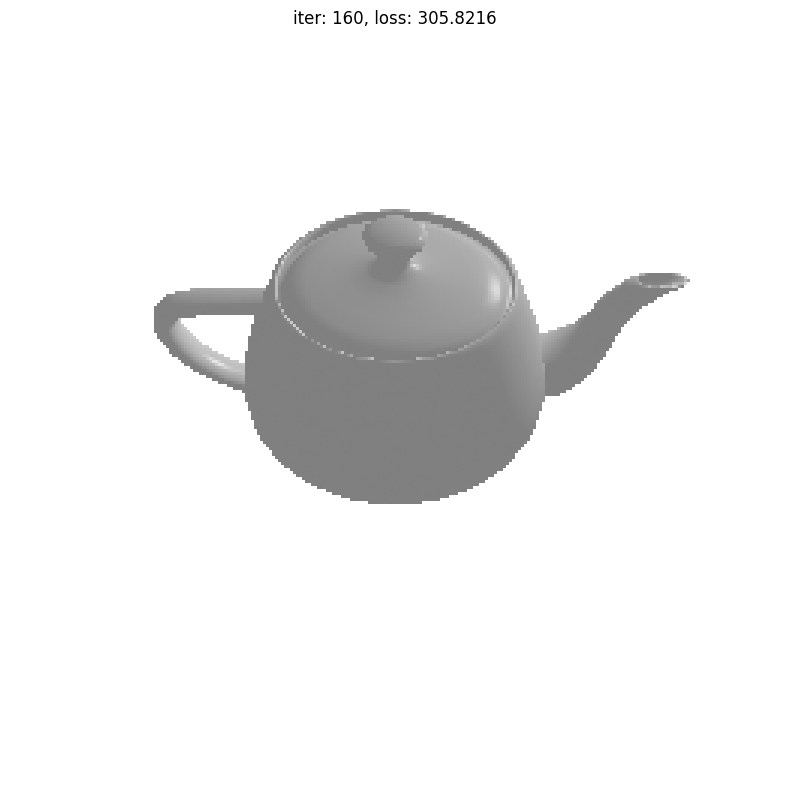

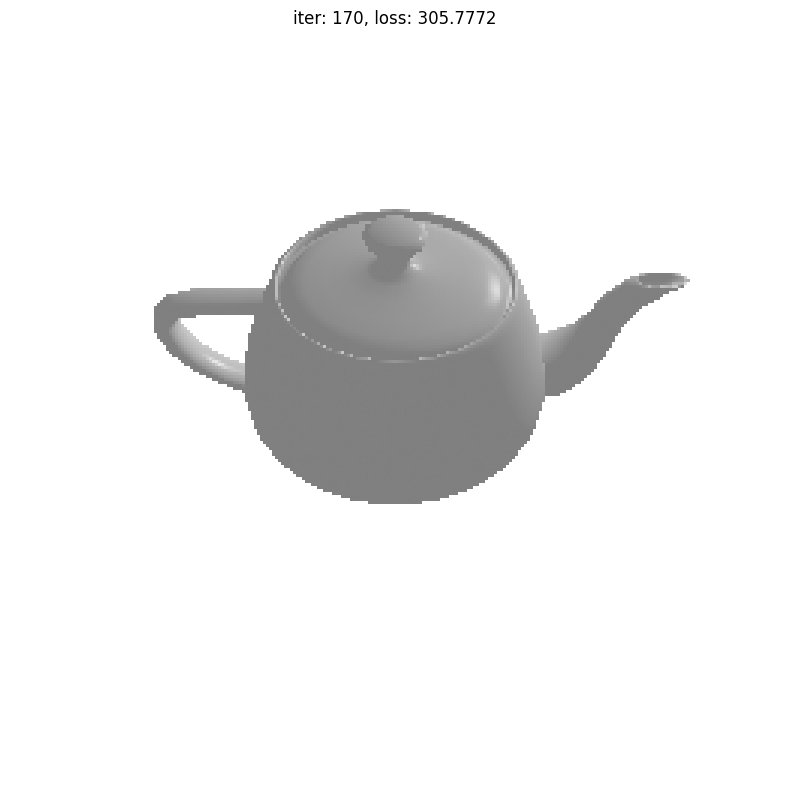

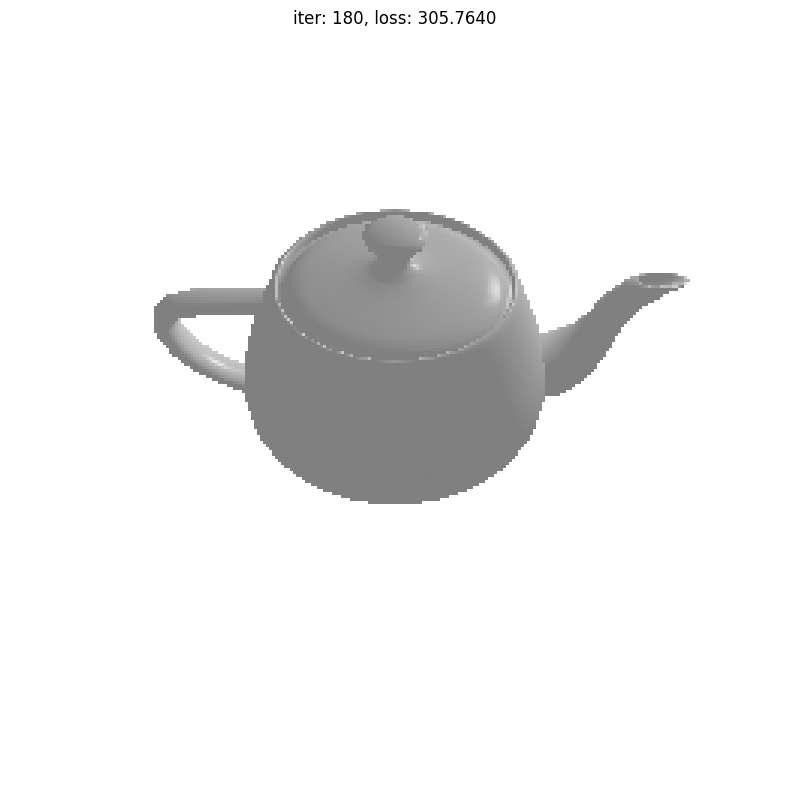

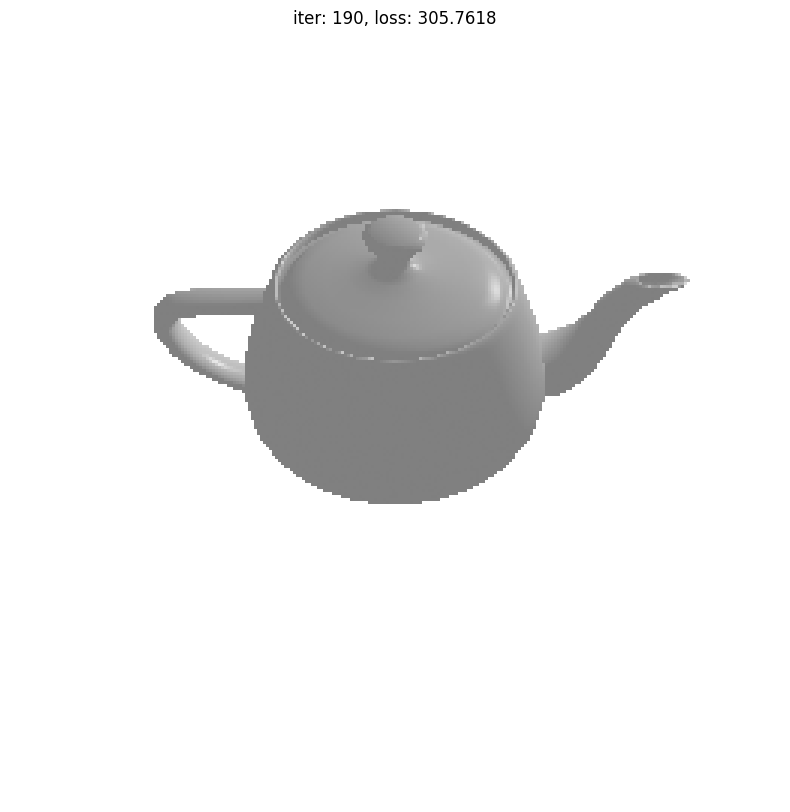

In [12]:
NUM_ITERS = 200
loop = tqdm(range(NUM_ITERS))

for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()

    loop.set_description("Optimizing (loss %.4f)" % loss.data)
    if i % 10 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)

        plt.figure(figsize=(10, 10))
        plt.imshow(image[..., :3])
        plt.title(f"iter: {i}, loss: {loss.data:.4f}")
        plt.grid(False)
        plt.axis("off")
        plt.show()

writer.close()